# MCOE of US Coal Plants based on FERC Form 1
This notebook is meant to generate some plots and statistics to demonstrate the fact that our database can access and explore the non-fuel expenses of coal fired power plants in the US.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..','..','..')))
from pudl import pudl, ferc1, eia923, settings, constants
from pudl import models, models_ferc1, models_eia923
from pudl import clean_eia923, clean_ferc1, clean_pudl
from pudl import analysis
import numpy as np
import pandas as pd
import sqlalchemy as sa
import matplotlib.pyplot as plt
import matplotlib as mpl
pudl_engine = pudl.db_connect_pudl()
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = (10,6)
mpl.rcParams['figure.dpi'] = 150

In [2]:
# First, identify all the FERC Coal plants, based on their fuel consumption patterns...
fuel_df = analysis.get_fuel_ferc1_df()
steam_df = analysis.get_steam_ferc1_df()
fuel_ferc1_proportions = analysis.plant_fuel_proportions_ferc1(fuel_df)
fuel_ferc1_proportions = fuel_ferc1_proportions.merge(analysis.primary_fuel_ferc1(fuel_df, fuel_thresh=0.5),
                                                      on=['report_year','respondent_id','plant_name'])
steam_fuel_df = steam_df.merge(fuel_ferc1_proportions,
                               on=['report_year','respondent_id','plant_name'])

In [3]:
def plot_fossil_mcoe(steam_fuel_df,
                     alpha=0.6,
                     normed=False,
                     weights='net_generation_mwh',
                     range=(10,130),
                     bins=60,
                     cumulative=False,
                     title='',
                     ymax=4e8,
                     wind=25):
    """Plot distribution of MCOE for coal and gas plants from FERC data."""
    coal_plants = steam_fuel_df[steam_fuel_df['primary_fuel']=='coal']
    plt.hist(coal_plants['expns_per_mwh'],
             weights=coal_plants[weights],
             bins=bins, range=range, alpha=alpha, normed=normed,
             label='Coal', cumulative=cumulative)
    
    gas_plants = steam_fuel_df[steam_fuel_df['primary_fuel']=='gas']
    plt.hist(gas_plants['expns_per_mwh'],
             weights=gas_plants[weights],
             bins=bins, range=range, alpha=alpha, normed=normed,
             label='Natural gas', cumulative=cumulative)
    
    plt.xlabel('$ / MWh')
    if cumulative:
        plt.ylabel('Proportion of Net generation (MWh)')
    else:
        plt.ylabel('Net generation (MWh)')
        
    plt.ylim(0,ymax)
    plt.title('US Fossil Plant MCOE (FERC Form 1, {})'.format(title))
    if(wind!=0):
        plt.vlines(wind, 0, ymax)
        plt.text(wind-2.5, ymax/2, 'Wind PPA: ${}/MWh'.format(wind), rotation=90)
    plt.legend();

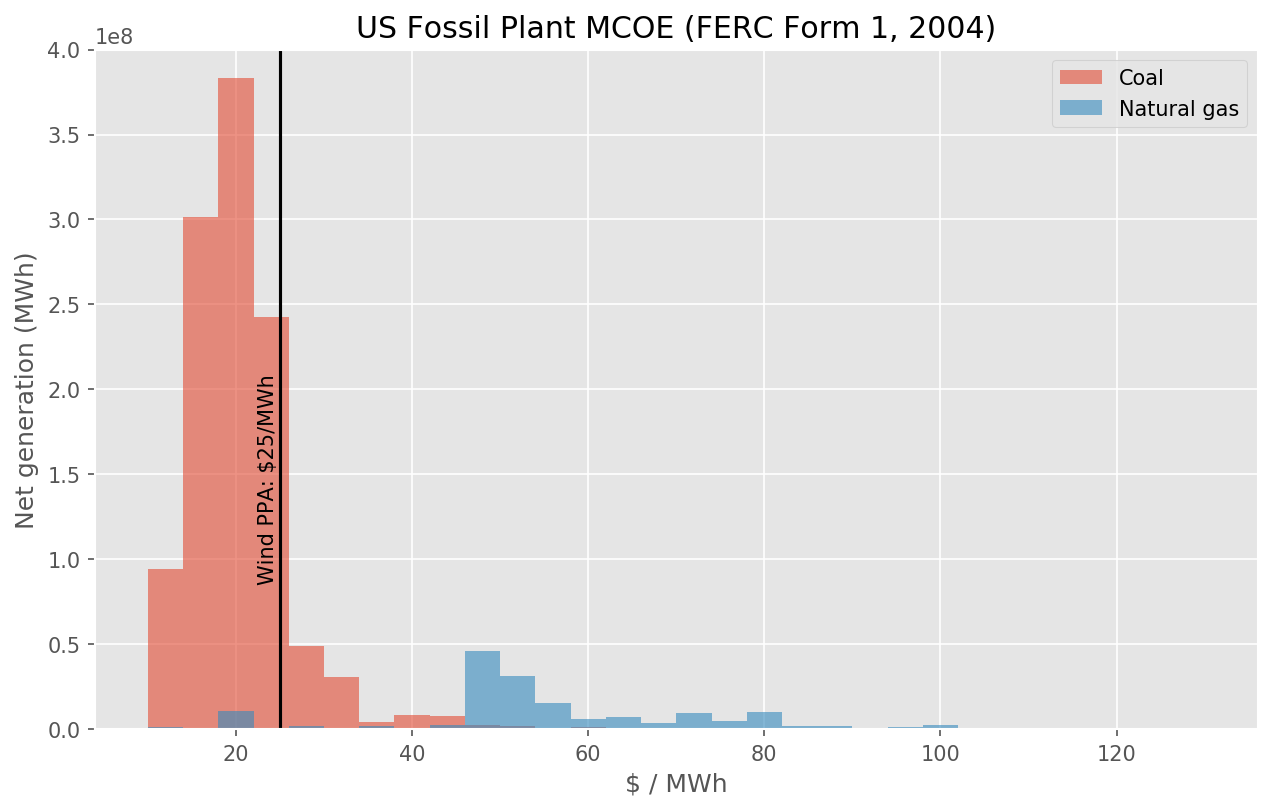

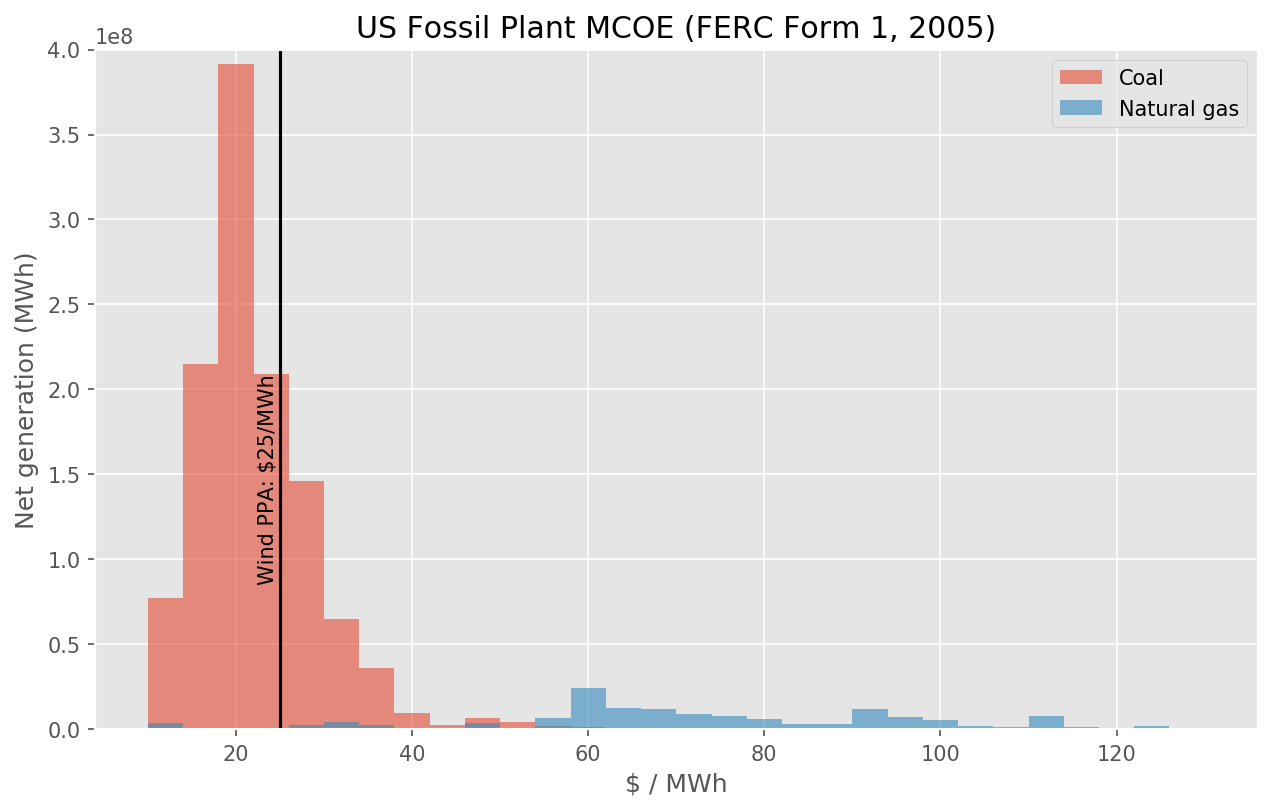

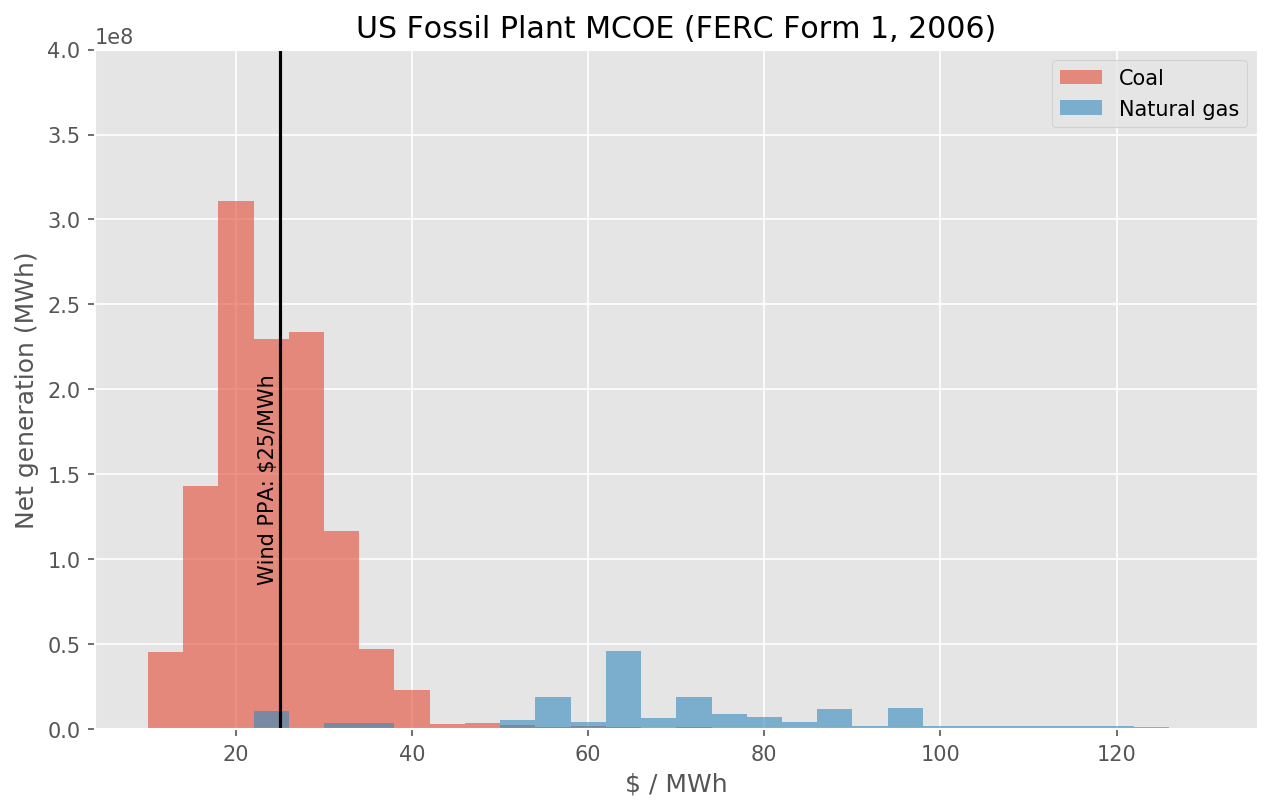

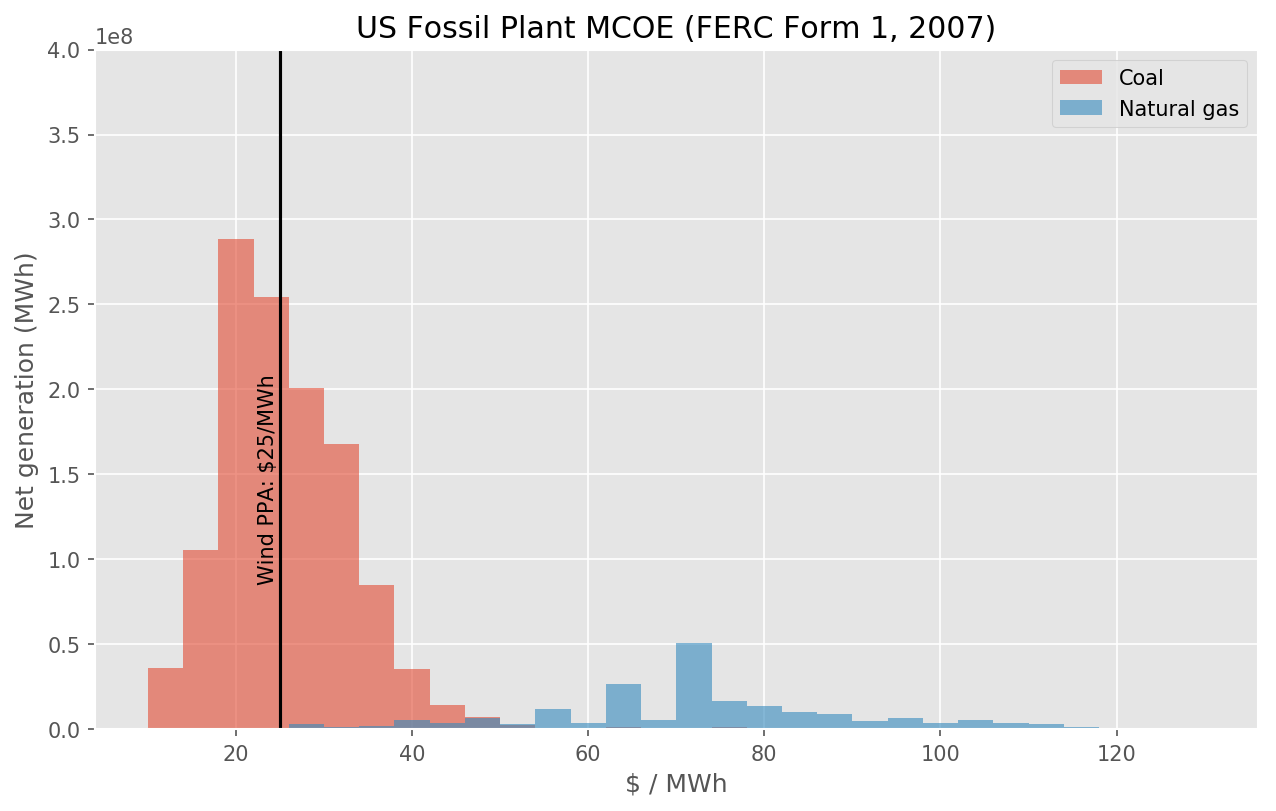

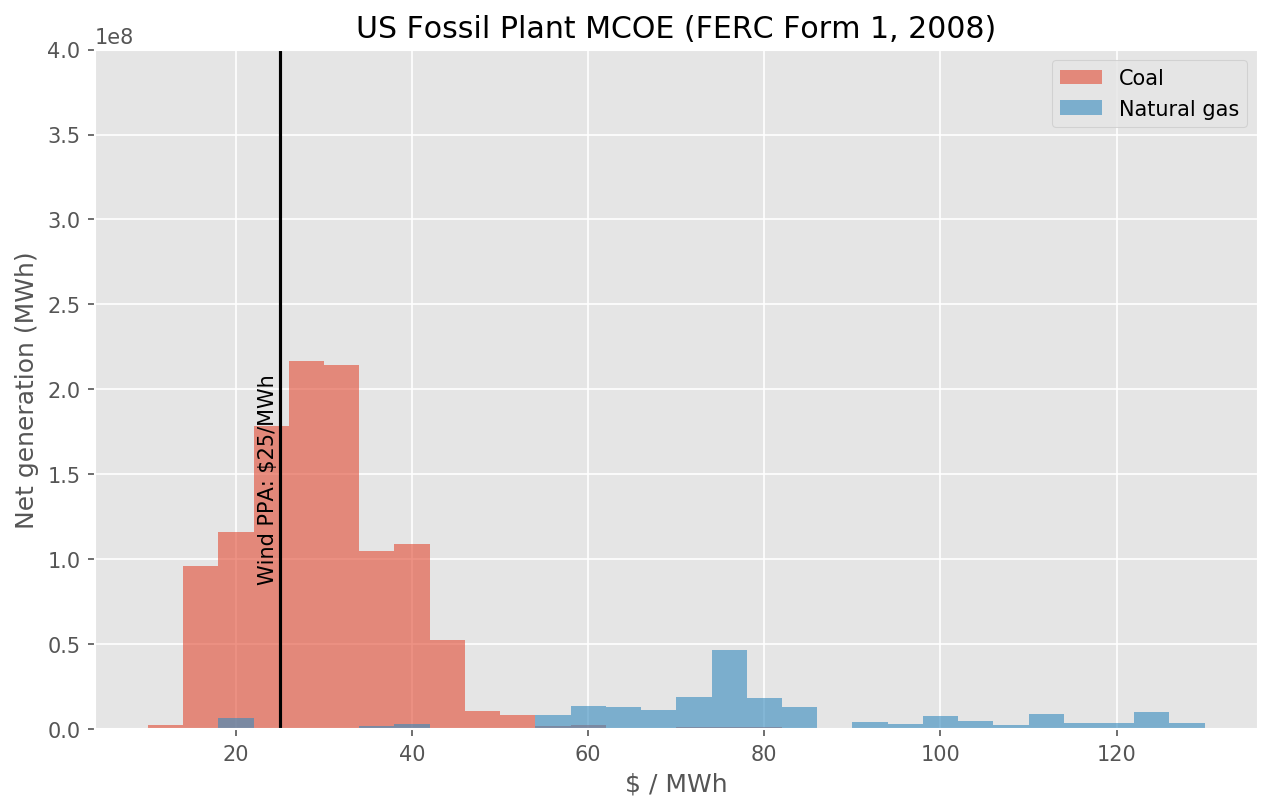

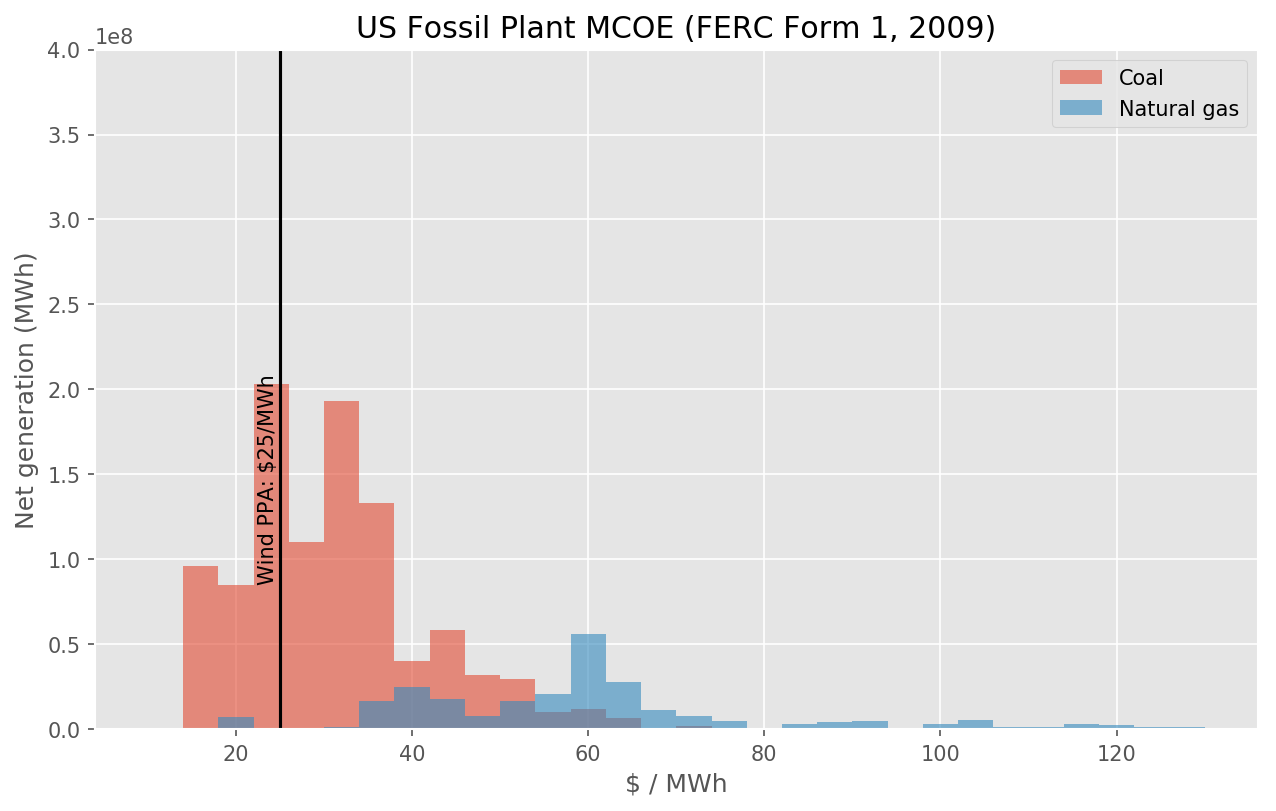

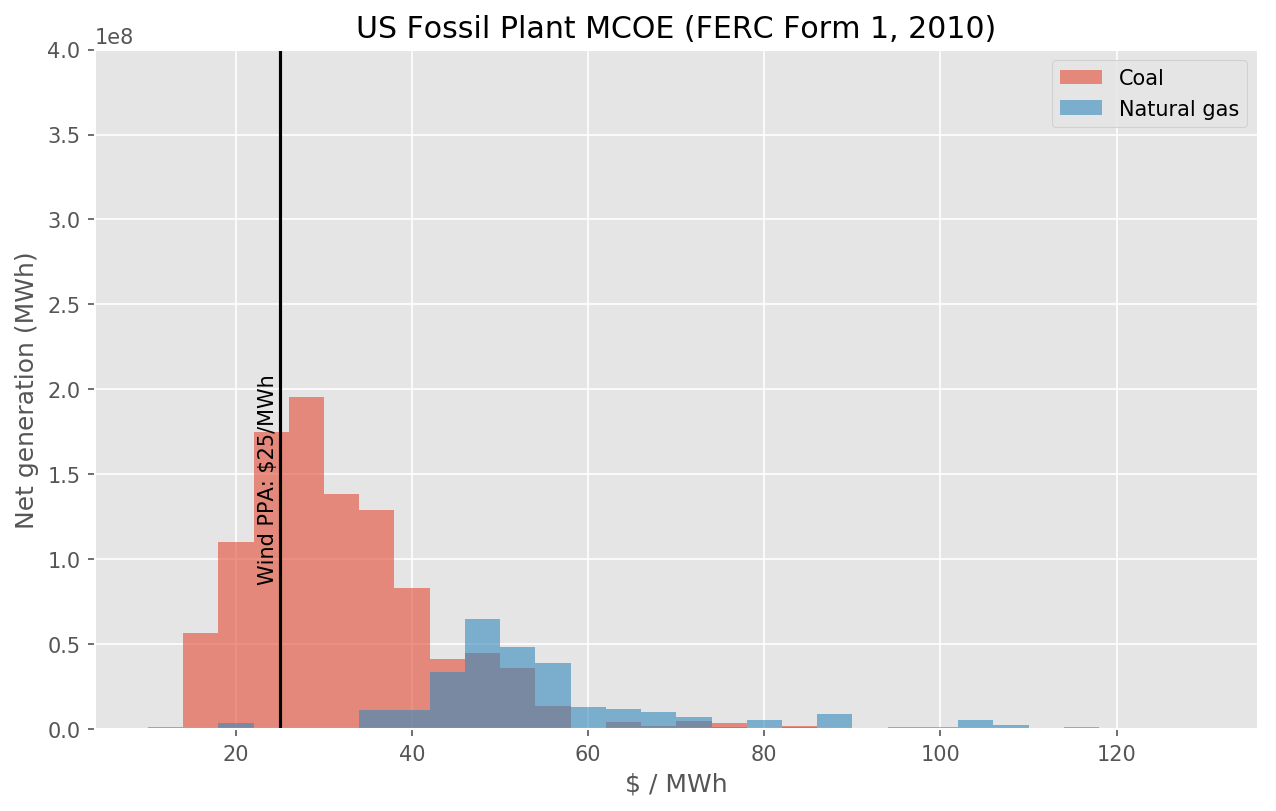

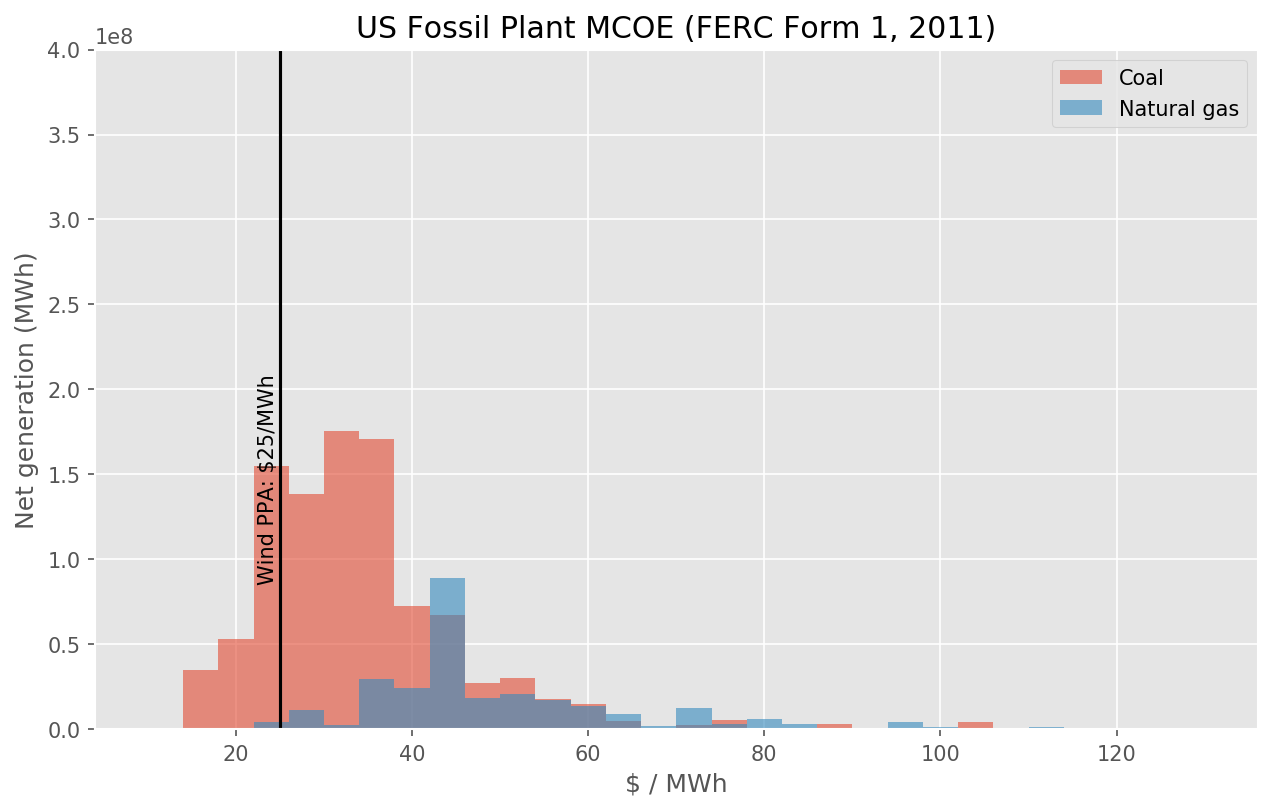

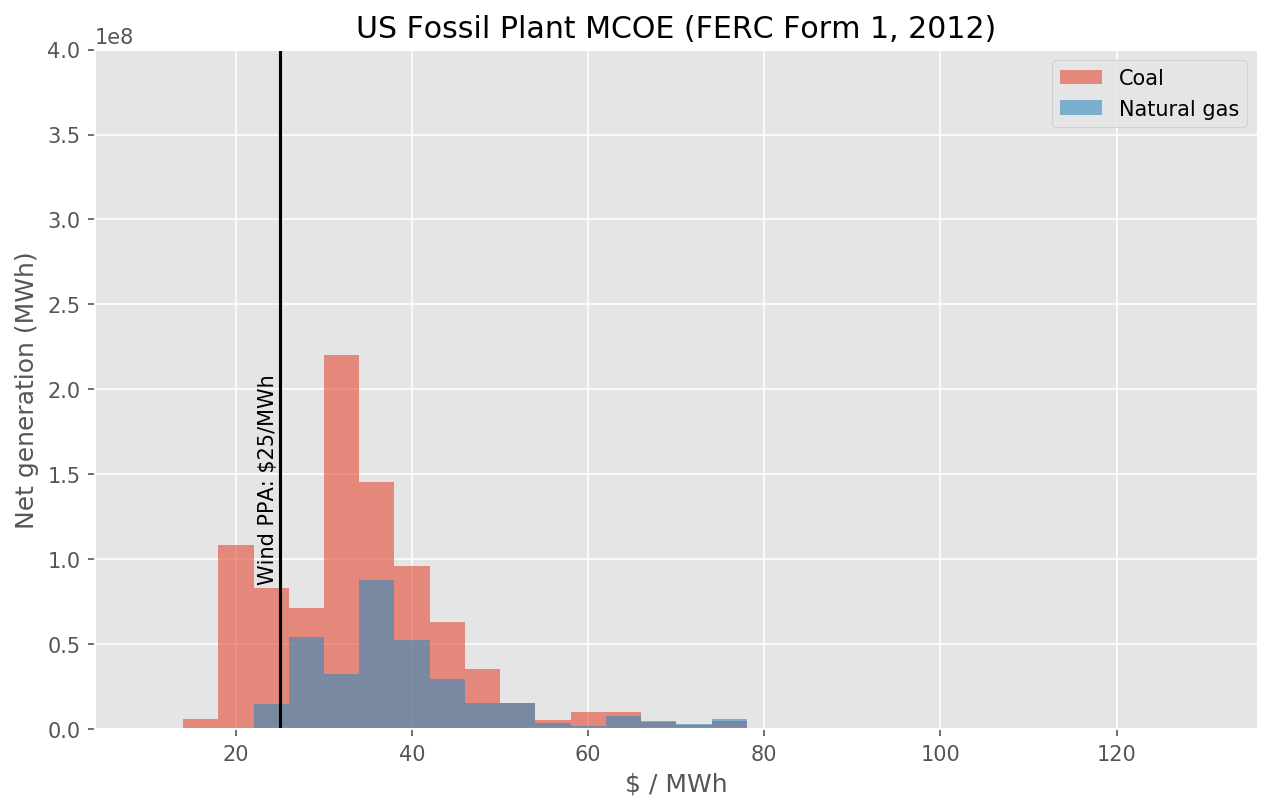

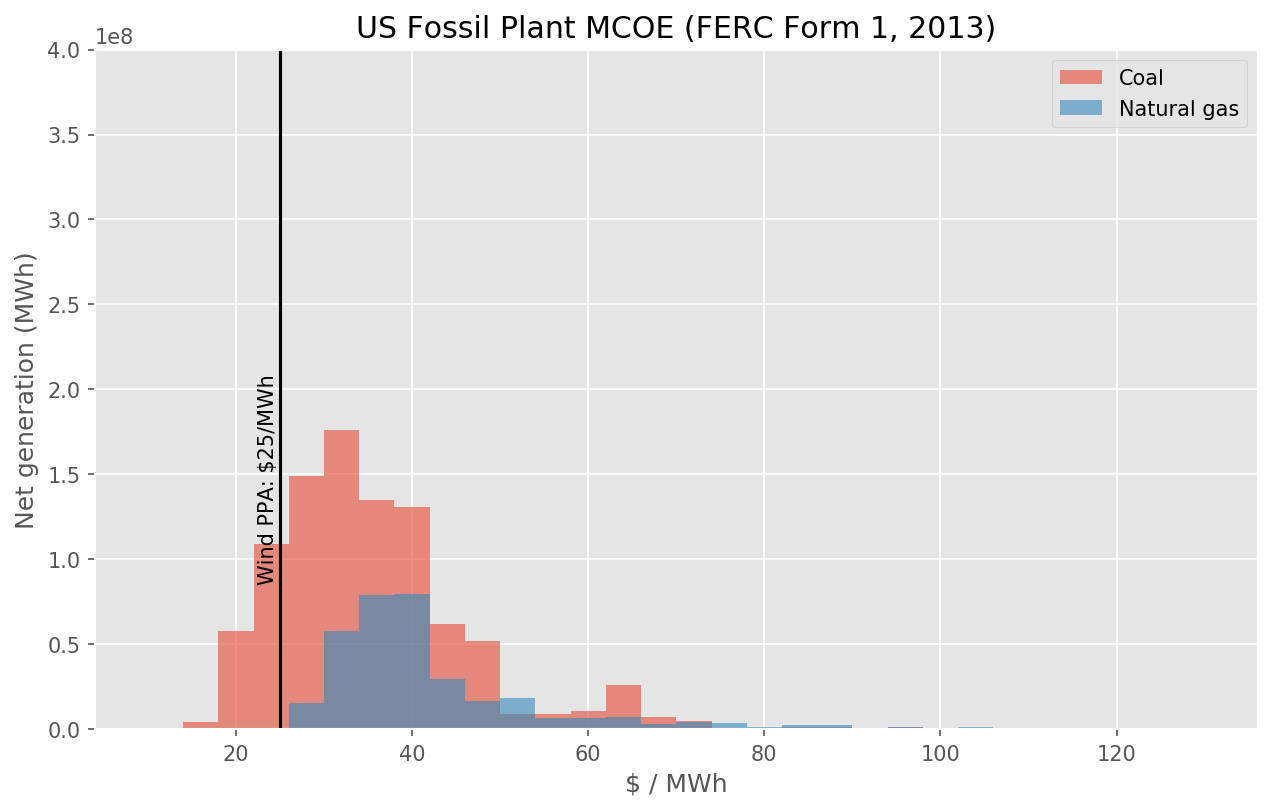

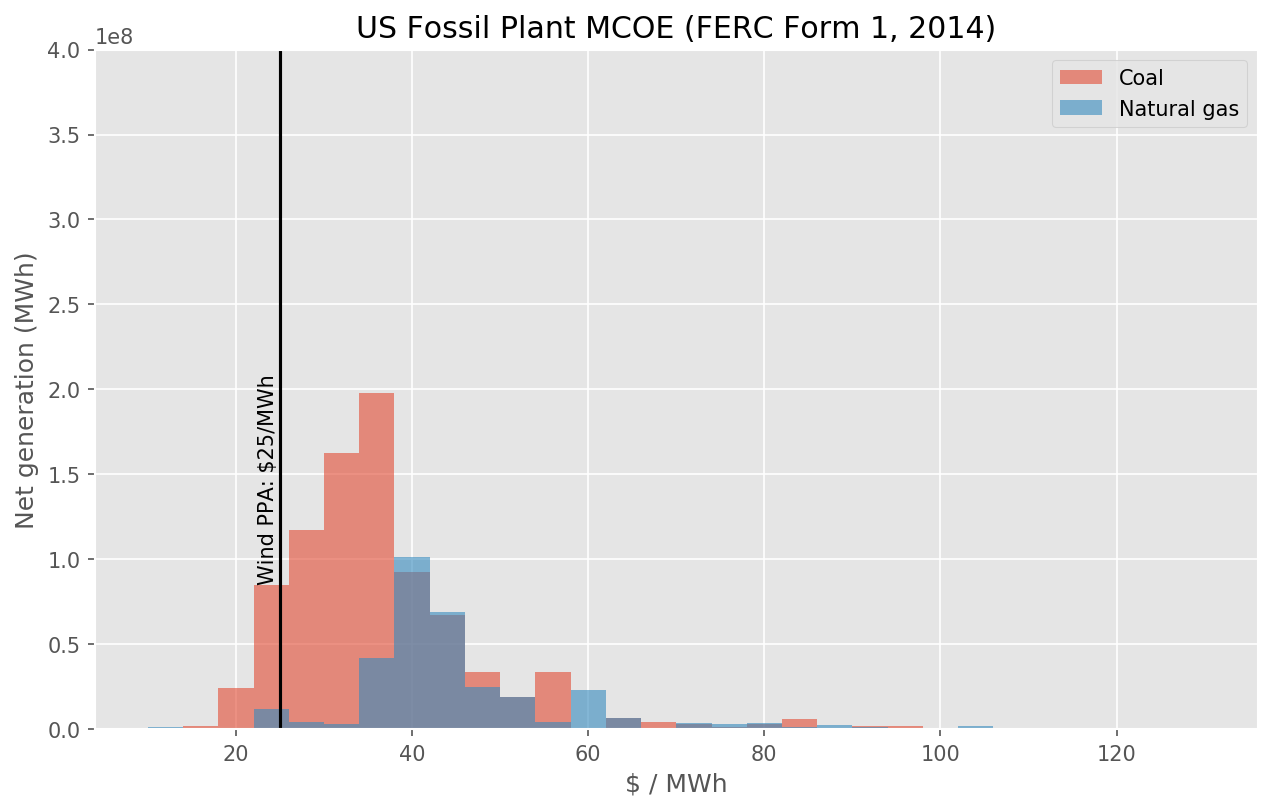

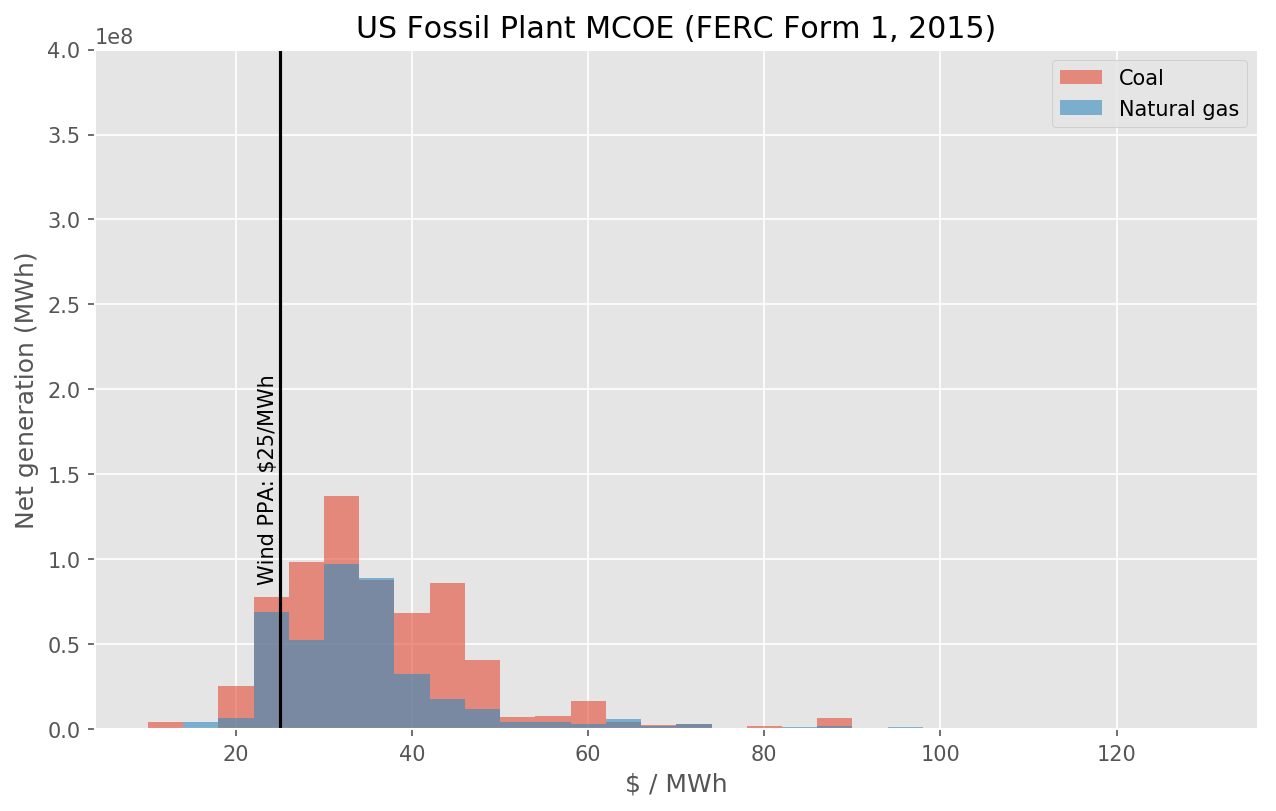

In [4]:
for year in range(2004,2016):
    plot_fossil_mcoe(steam_fuel_df[steam_fuel_df['report_year']==year], title=year, bins=30, wind=25, ymax=4e8)
    plt.savefig('ferc1_coal_gas_mcoe_{}.png'.format(year))
    plt.show()

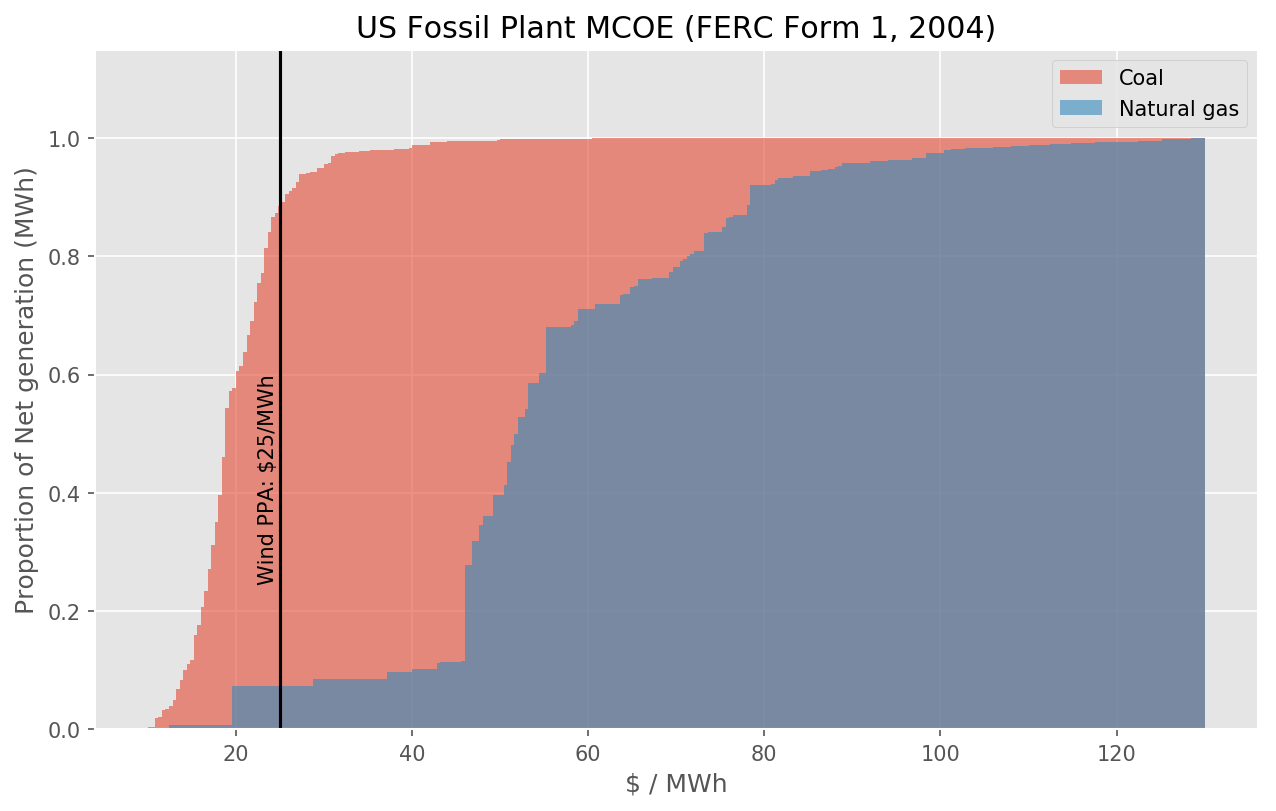

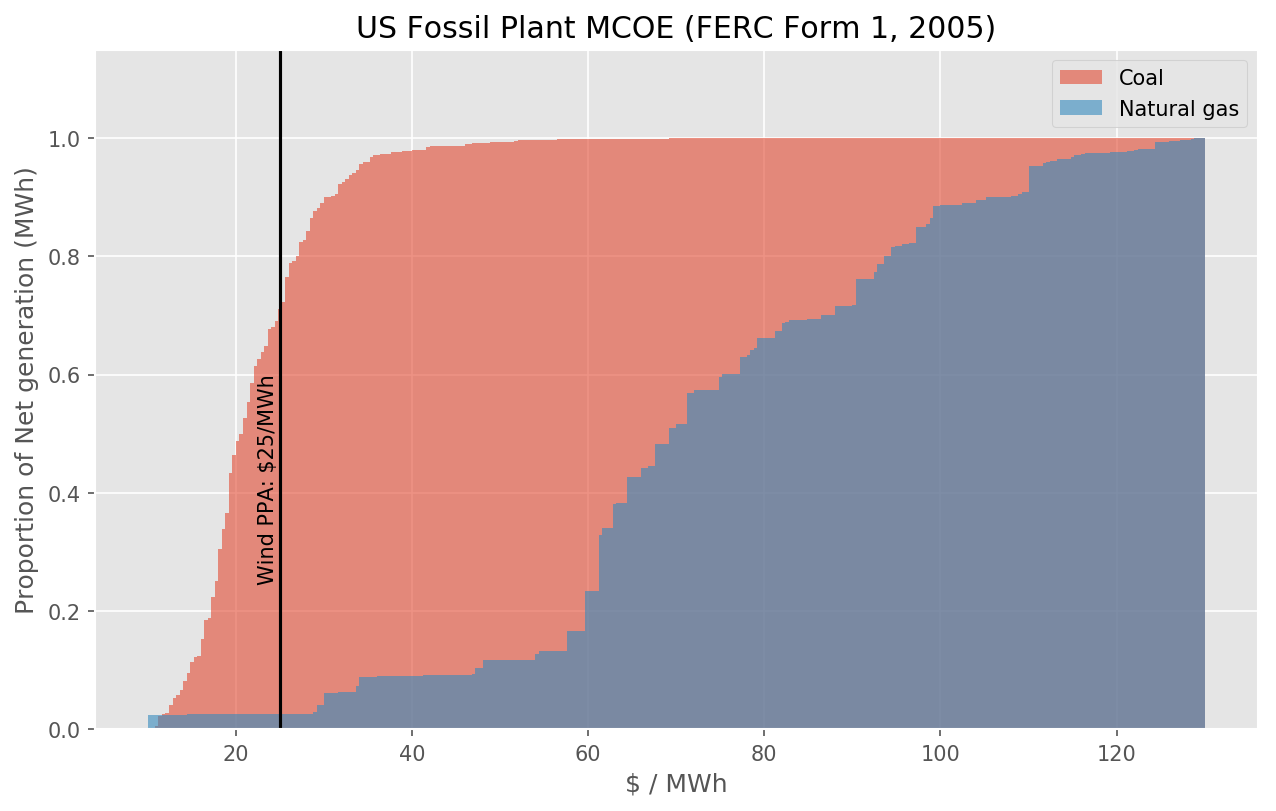

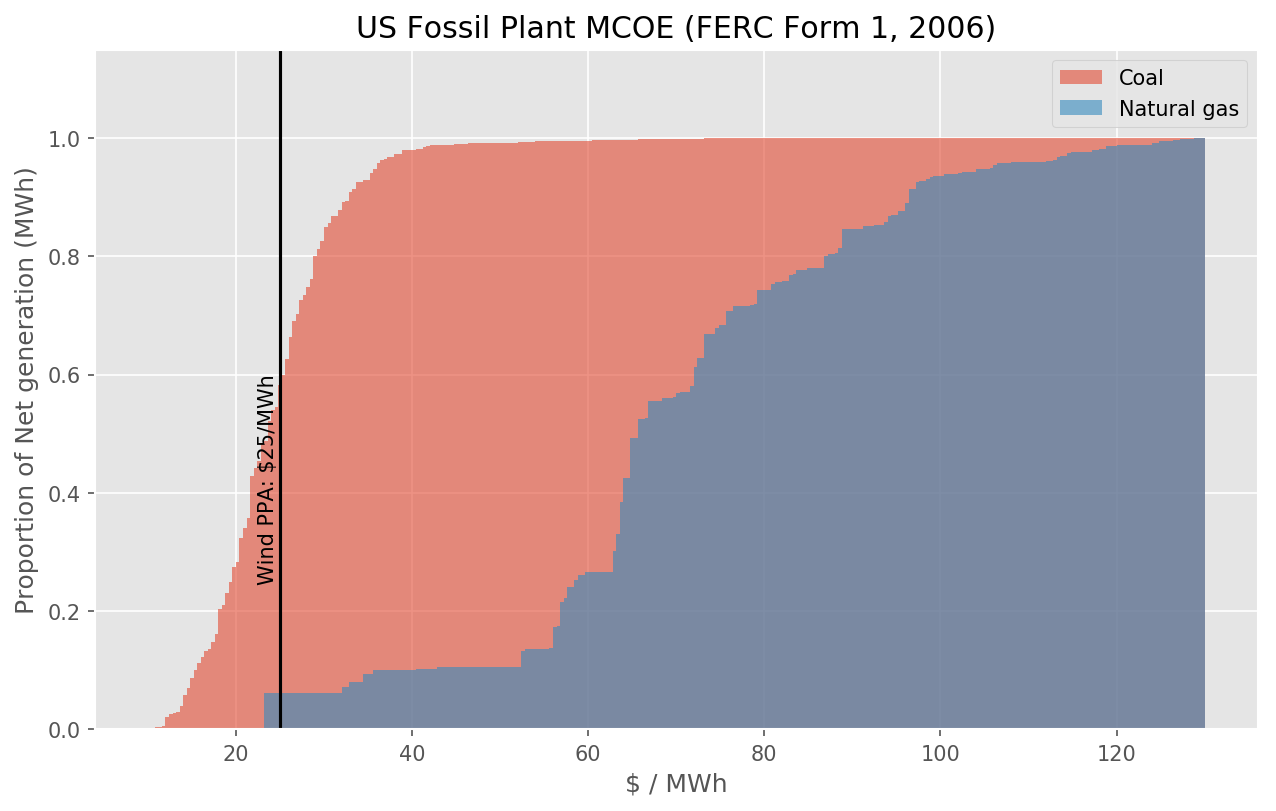

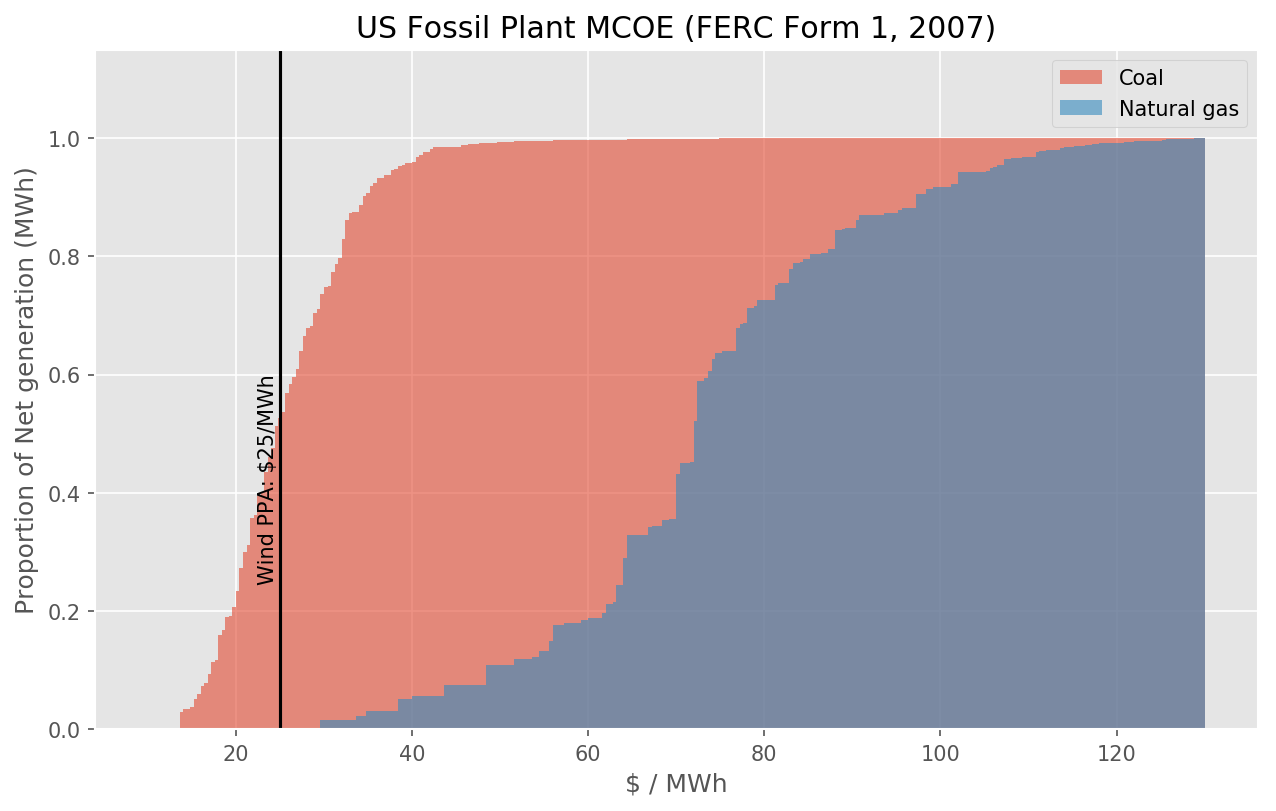

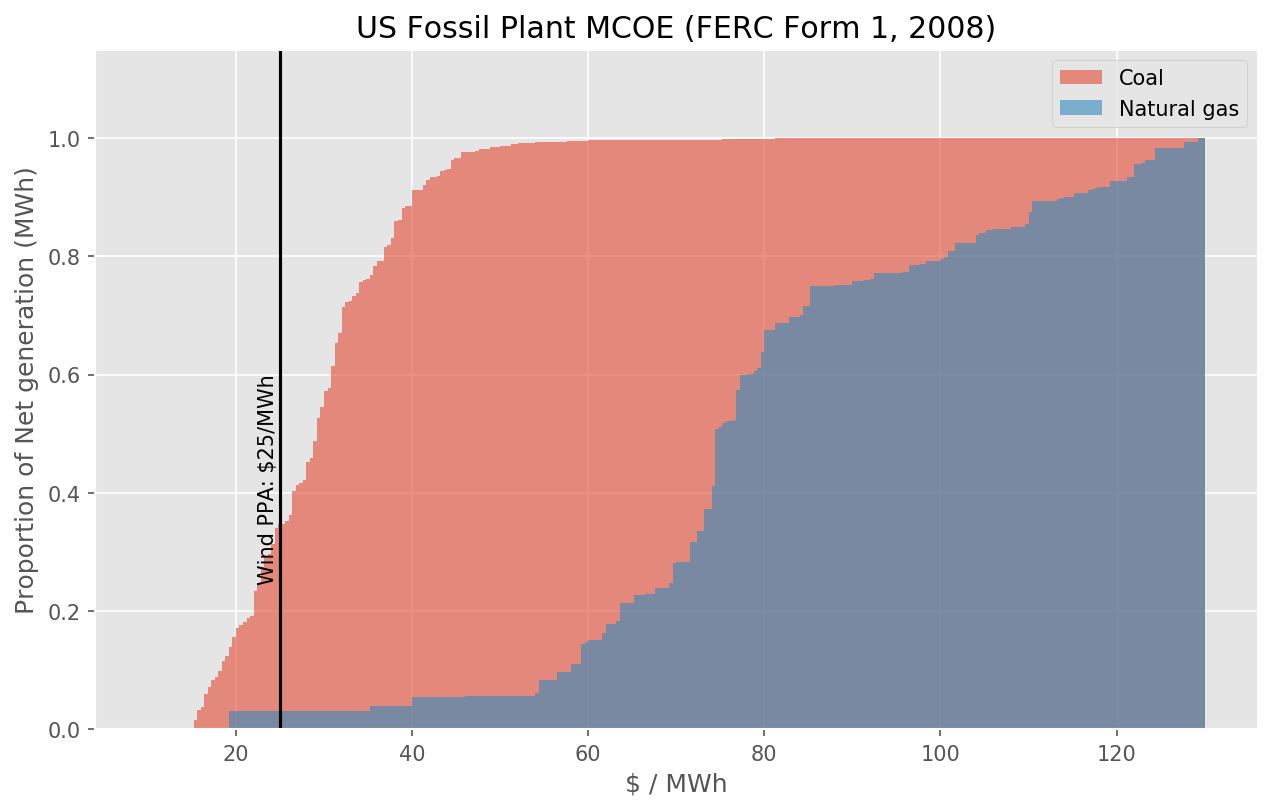

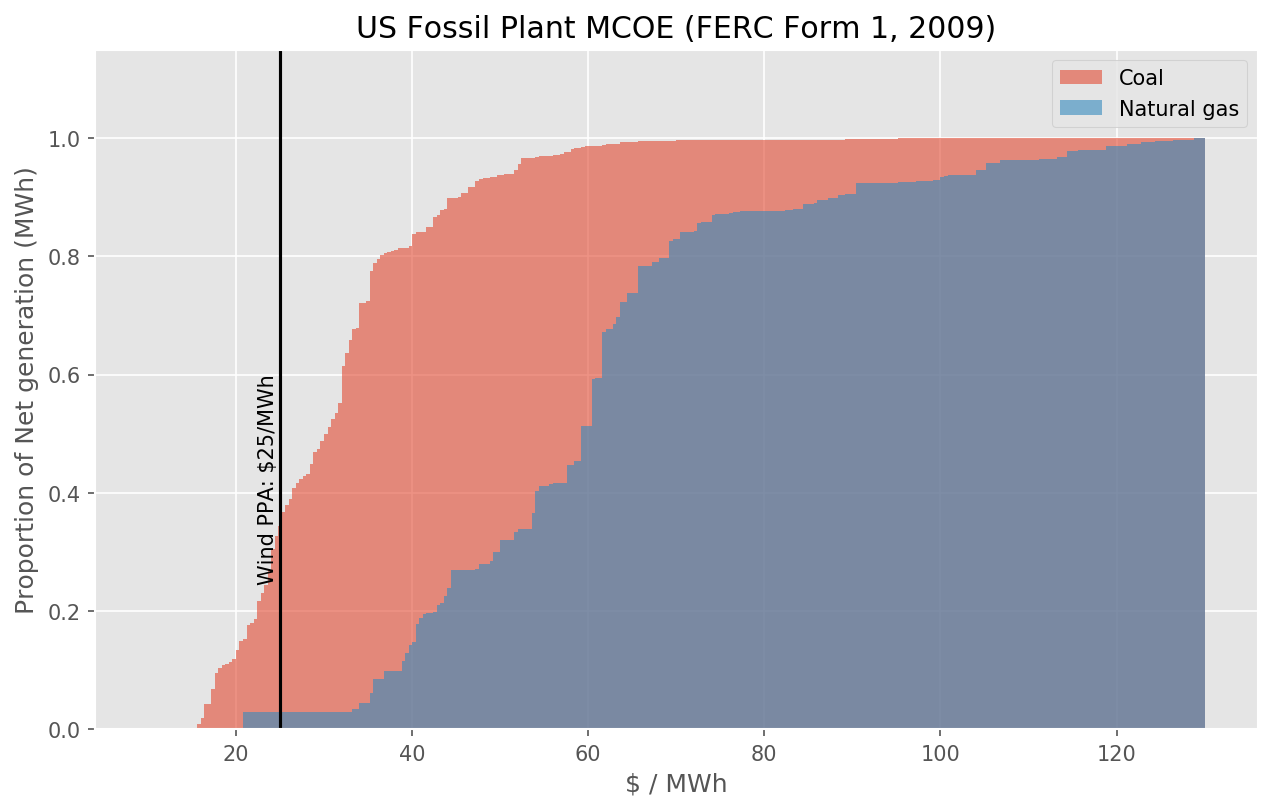

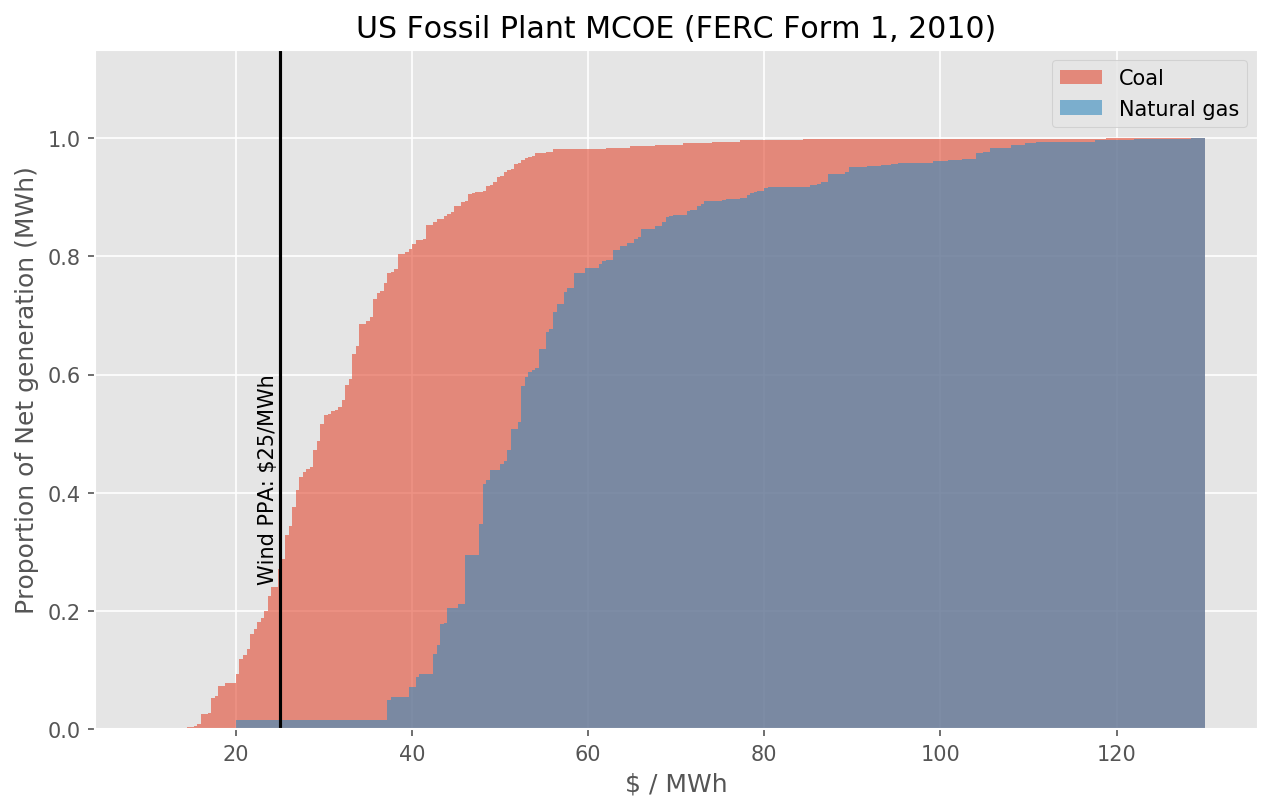

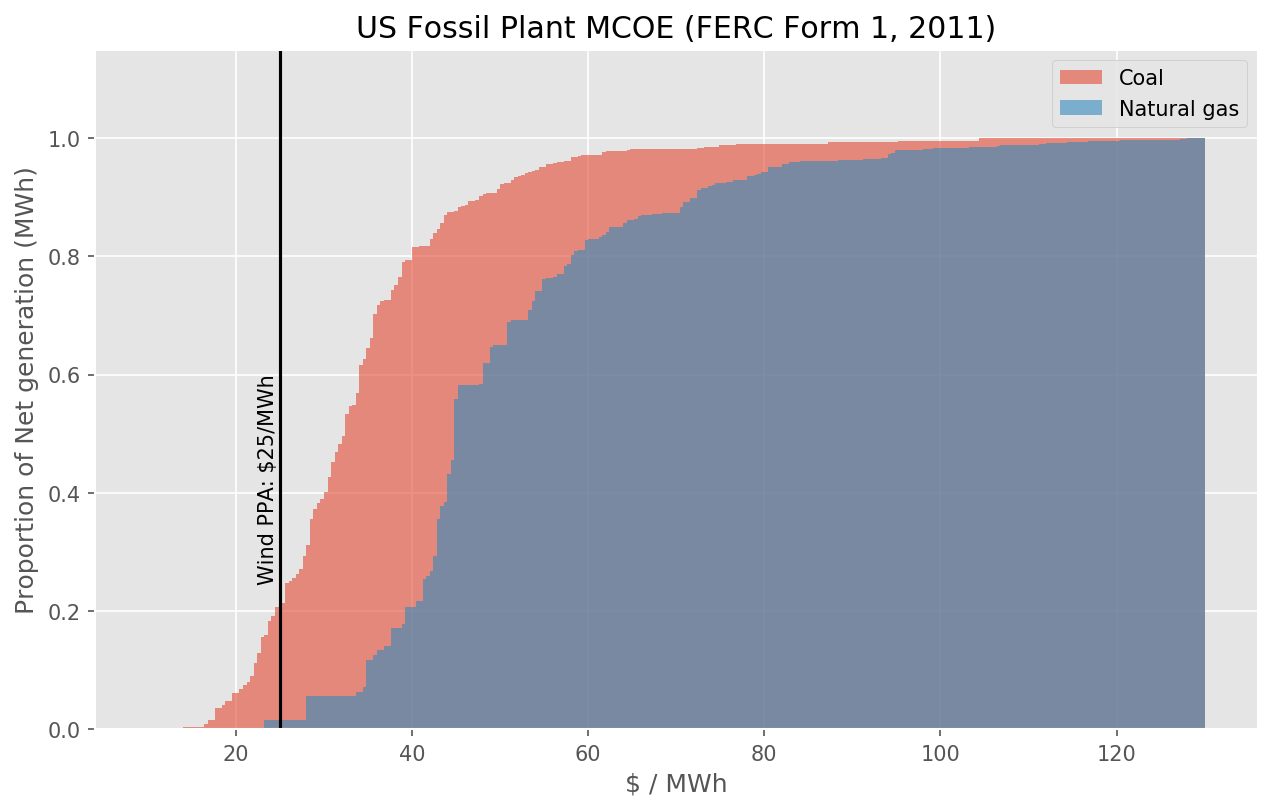

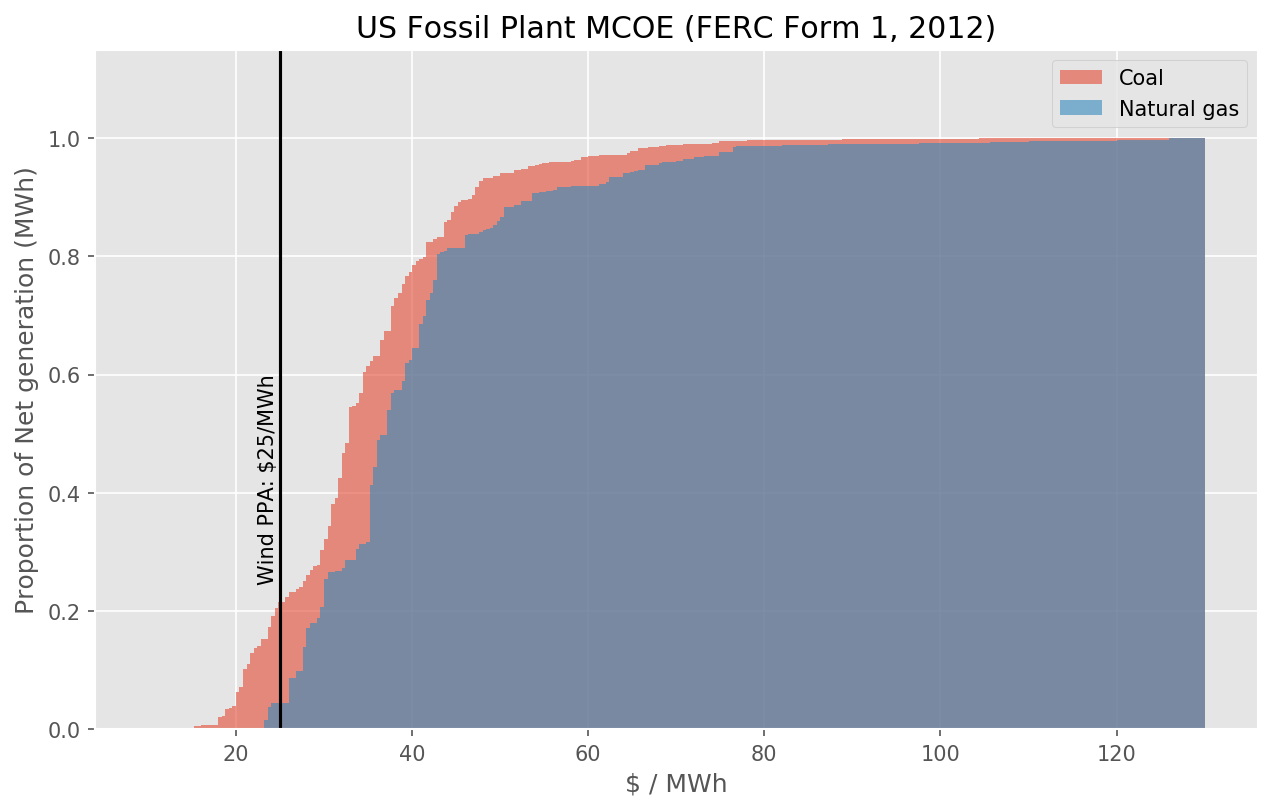

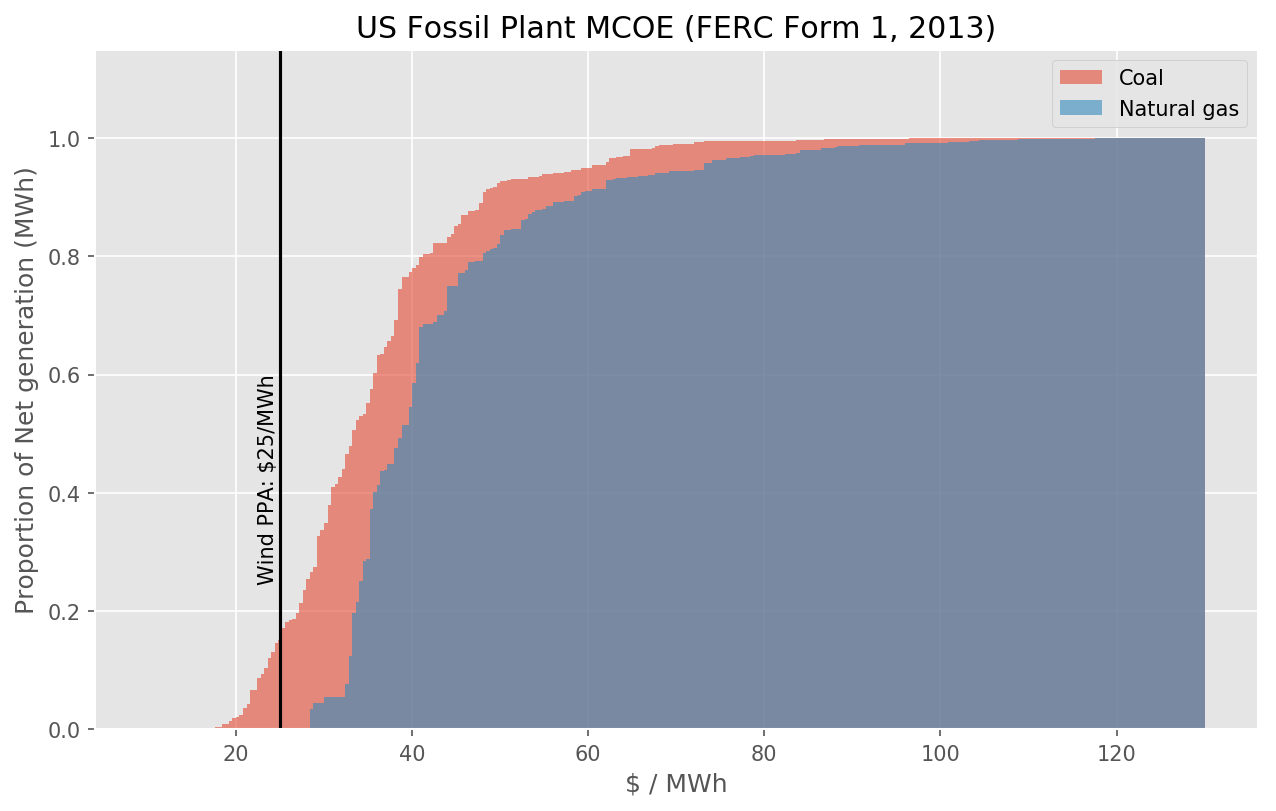

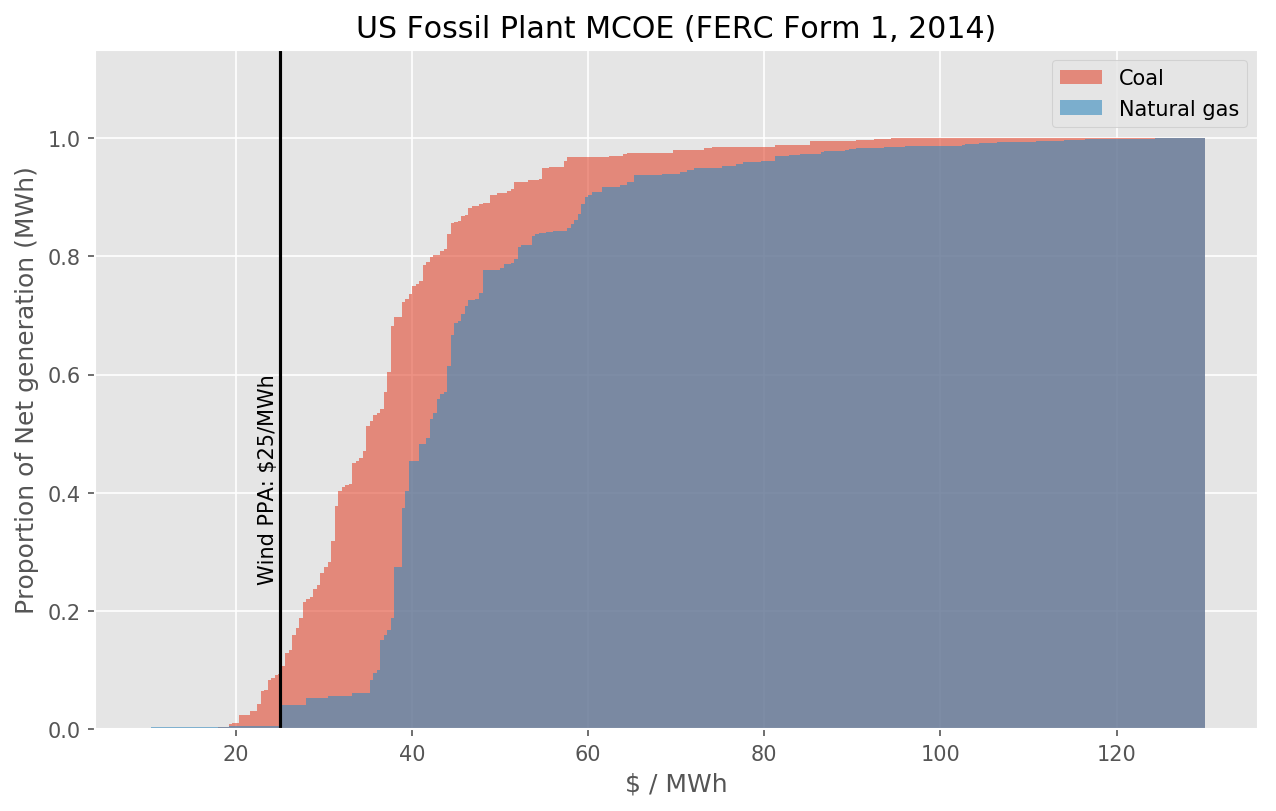

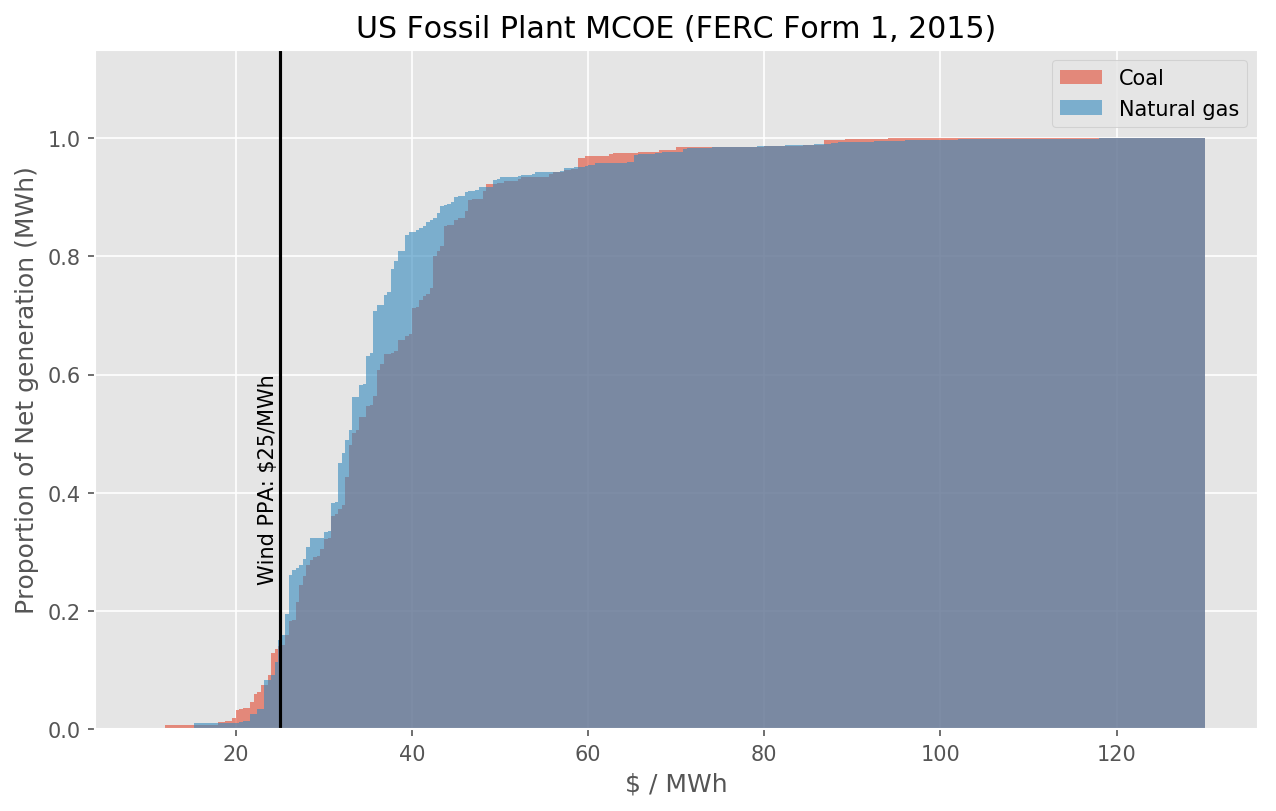

In [5]:
for year in range(2004,2016):
    plot_fossil_mcoe(steam_fuel_df[steam_fuel_df['report_year']==year],
                     title=year,
                     bins=300,
                     wind=25,
                     cumulative=True,
                     normed=True,
                     ymax=1.15)
    plt.savefig('ferc1_coal_gas_mcoe_cum_{}.png'.format(year))
    plt.show()